<a href="https://colab.research.google.com/github/shakasom/zonalstatistics/blob/master/Zonal_Statistics_Sentinel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Installations
!apt install gdal-bin python-gdal python3-gdal 
!pip install rasterio
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk1.8.0_231.jdk/Contents/Home/bin/apt" (-1)
     |████████████████████████████████| 23.7MB 5.1MB/s eta 0:00:01
Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk1.8.0_231.jdk/Contents/Home/bin/apt" (-1)
  Cloning git://github.com/geopandas/geopandas.git to /private/var/folders/zx/h977wcn147q8tbl_zhw__mdm0000gn/T/pip-req-build-dea7nhxk
  Running command git clone -q git://github.com/geopandas/geopandas.git /private/var/folders/zx/h977wcn147q8tbl_zhw__mdm0000gn/T/pip-req-build-dea7nhxk
  Created wheel for geopandas: filename=geopandas-0.6.1+11.g00d9fd2-py2.py3-none-any.whl size=919545 sha256=2e2166c323446fe29b2c983bfd6876f3c5ad3d996c33c4632929ca9394630305
  Stored in directory: /private/var/folders/zx/h977wcn147q8tbl_zhw__mdm0000gn/T/pip-ephem-wheel-cache-ueuyx7ho/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas
  Found existing installation: geopanda

In [2]:
!pip install mapclassify

  Created wheel for mapclassify: filename=mapclassify-2.1.1-cp37-none-any.whl size=29001 sha256=0a3917e8cc3761645017591cc76033c6681c63c667daa838c37607960c9dc3ba
  Stored in directory: /Users/bhaumikmehta/Library/Caches/pip/wheels/fc/b8/58/56b650743289cbecb476ef1fc50ab0aeaa0b12e56ad912d624
Successfully built mapclassify


In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
!wget https://www.dropbox.com/s/gf51dybqbujyjb2/Data.zip

--2019-11-13 22:03:55--  https://www.dropbox.com/s/gf51dybqbujyjb2/Data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.83.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.83.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gf51dybqbujyjb2/Data.zip [following]
--2019-11-13 22:03:55--  https://www.dropbox.com/s/raw/gf51dybqbujyjb2/Data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce0b43f6d973d904e1362d414fa.dl.dropboxusercontent.com/cd/0/inline/AsRvMGbW6vC-n9w4Zyw64EbpazdioKMtxoXNHdu8z0mJpAw_k1fRYIi05c0JUBO-RWTFEfGEd5StjJdV2ht-d-Gz__T95n9BzGQQBUaRmEhzwdBI0PksjL4GZLafC_soRmQ/file# [following]
--2019-11-13 22:03:56--  https://uce0b43f6d973d904e1362d414fa.dl.dropboxusercontent.com/cd/0/inline/AsRvMGbW6vC-n9w4Zyw64EbpazdioKMtxoXNHdu8z0mJpAw_k1fRYIi05c0JUBO-RWTFEfGEd5StjJdV2ht-d-Gz__T95n9BzGQQBUaRmEhzwdBI0PksjL4GZLafC_soRmQ/file
Resolving uce0

In [7]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
   creating: Data/20191002/
  inflating: Data/20191002/B02-20191002.tif  
  inflating: Data/20191002/B03-20191002.tif  
  inflating: Data/20191002/B04-20191002.tif  
  inflating: Data/20191002/B08-20191002.tif  
   creating: Data/20191101/
  inflating: Data/20191101/B02-20191101.tif  
  inflating: Data/20191101/B03-20191101.tif  
  inflating: Data/20191101/B04-20191101.tif  
  inflating: Data/20191101/B08-20191101.tif  
   creating: Data/shapefiles/
 extracting: Data/shapefiles/boundary.cpg  
  inflating: Data/shapefiles/boundary.dbf  
  inflating: Data/shapefiles/boundary.prj  
  inflating: Data/shapefiles/boundary.qpj  
  inflating: Data/shapefiles/boundary.shp  
  inflating: Data/shapefiles/boundary.shx  
 extracting: Data/shapefiles/osm_buildings.cpg  
  inflating: Data/shapefiles/osm_buildings.dbf  
  inflating: Data/shapefiles/osm_buildings.prj  
  inflating: Data/shapefiles/osm_buildings.qpj  
  inflating: Data/shapefiles/osm_buildings.shp  

In [20]:
b8 = rio.open("/content/Data/20191101/B08-20191101.tif")
b4 = rio.open("/content/Data/20191101/B04-20191101.tif")
b3 = rio.open("/content/Data/20191101/B03-20191101.tif")
b2 = rio.open("/content/Data/20191101/B02-20191101.tif")

In [21]:

b4.count, b4.width, b4.height

(1, 479, 429)

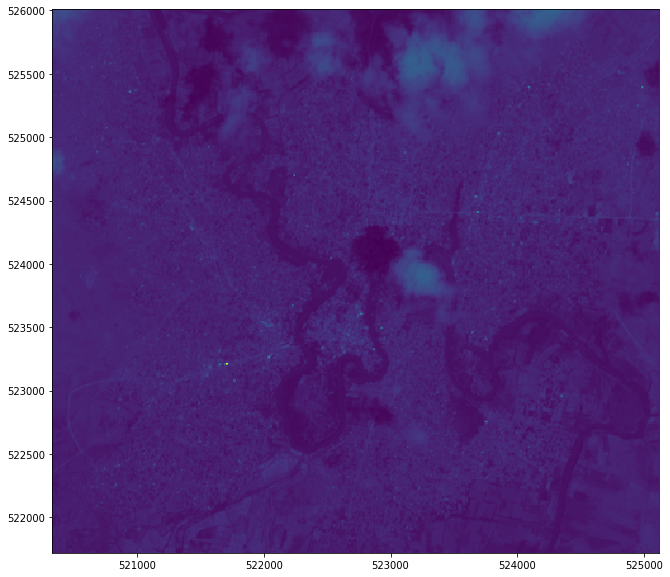

In [22]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(b3, ax=ax)
plt.show()

In [24]:
buildings = gpd.read_file("/content/Data/shapefiles/osm_buildings.shp")
buildings = buildings[["osm_id","building", "geometry"]]
buildings.head()


,osm_id,building,geometry
0,8275560,yes,"POLYGON ((521839.828 524323.388, 521837.607 52..."
1,8276697,yes,"POLYGON ((522700.756 523641.273, 522727.020 52..."
2,8280395,yes,"POLYGON ((523000.403 523492.953, 523003.418 52..."
3,None,yes,"POLYGON ((521087.015 523190.338, 521095.931 52..."
4,None,yes,"POLYGON ((521096.268 523212.801, 521104.110 52..."


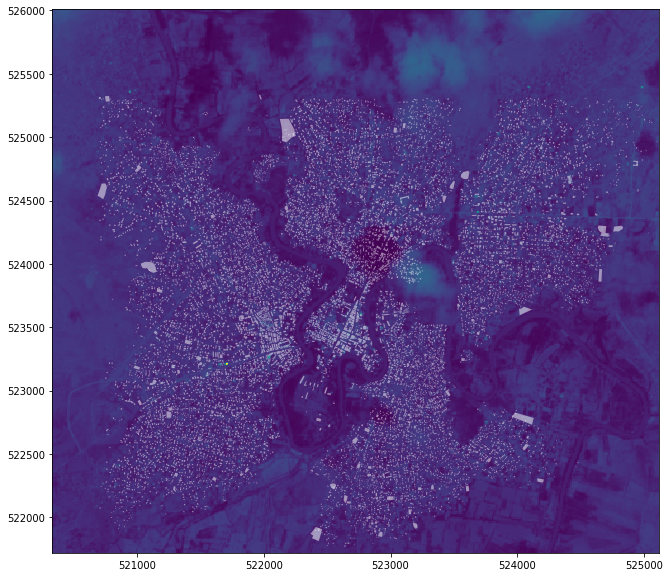

In [25]:
fig, ax = plt.subplots(figsize=(12, 10))
show(b4, ax=ax)
buildings.plot(ax=ax, color="white", alpha=.50)
plt.show();

## Calculate NDWI

In [26]:
green = b3.read()
nir = b8.read()
ndwi = (nir.astype(float)-green.astype(float))/(nir+green)

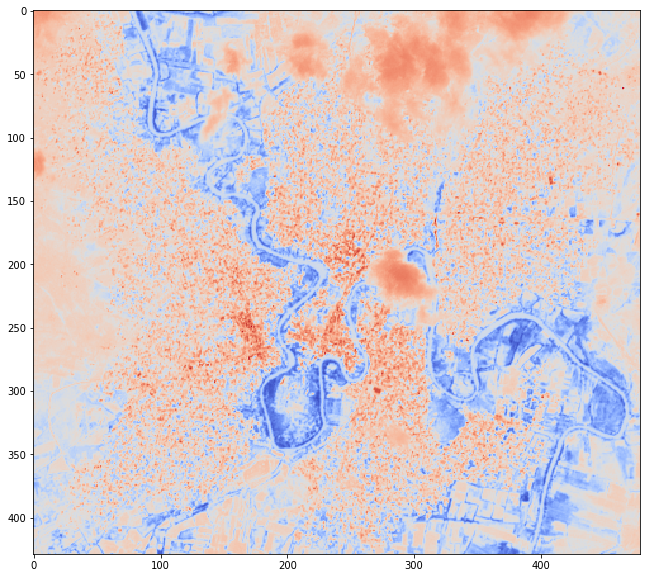

In [27]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(ndwi, ax=ax, cmap="coolwarm_r")
plt.show()

In [29]:
meta = b4.meta

meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

with rio.open('NDWI.tif', 'w', **meta) as dst:
    dst.write(ndwi.astype(rio.float32))

In [30]:
ndwi_raster = rio.open("NDWI.tif")

In [31]:
masked, mask_transform = mask(dataset=ndwi_raster, 
                              shapes=buildings.geometry, crop=True)

In [32]:
masked

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.08934842, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

In [33]:
masked.mean()

0.013454553

In [34]:
masked.max()

0.57300335

In [35]:
b4.crs

CRS.from_epsg(32638)

In [36]:
buildings.crs

{'init': 'epsg:32638'}

In [38]:
buildings = buildings.to_crs(ndwi_raster.crs)

In [39]:
def derive_stats(geom, data=ndwi_raster, **mask_kw):
    masked, mask_transform = mask(dataset=data, shapes=(geom,),
                                  crop=True, all_touched=True, filled=True)
    return masked

In [40]:
buildings['mean_ndwi'] = buildings.geometry.apply(derive_stats).apply(np.mean)

In [41]:
buildings['max_ndwi'] = buildings.geometry.apply(derive_stats).apply(np.max)

In [42]:
buildings.head()

,osm_id,building,geometry,mean_ndwi,max_ndwi
0,8275560,yes,"POLYGON ((521839.828 524323.388, 521837.607 52...",0.207663,0.263993
1,8276697,yes,"POLYGON ((522700.756 523641.273, 522727.020 52...",0.066127,0.255757
2,8280395,yes,"POLYGON ((523000.403 523492.953, 523003.418 52...",0.067684,0.247811
3,None,yes,"POLYGON ((521087.015 523190.338, 521095.931 52...",0.186061,0.268627
4,None,yes,"POLYGON ((521096.268 523212.801, 521104.110 52...",0.187913,0.265823


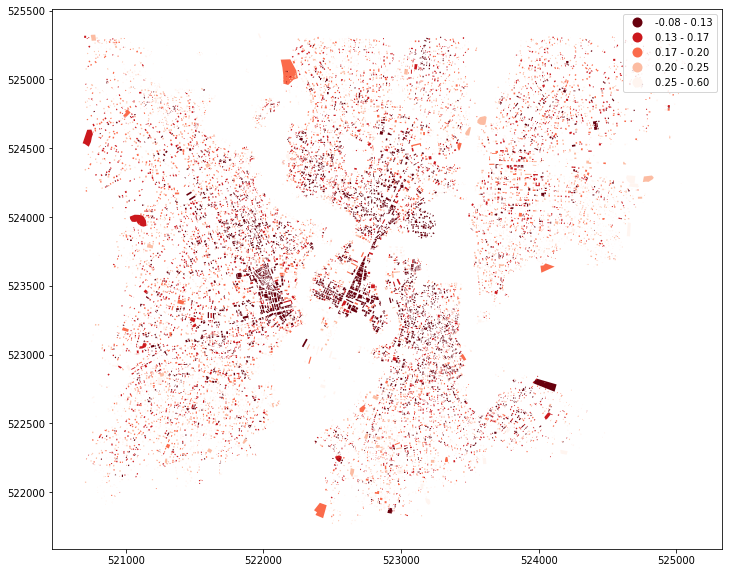

In [43]:
fig, ax = plt.subplots(figsize=(12,10))
buildings.plot(column="mean_ndwi", ax=ax, cmap="Reds_r", scheme='quantiles', legend=True)

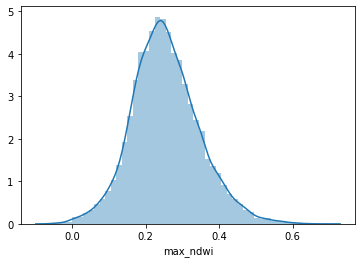

In [44]:
sns.distplot(buildings.max_ndwi)

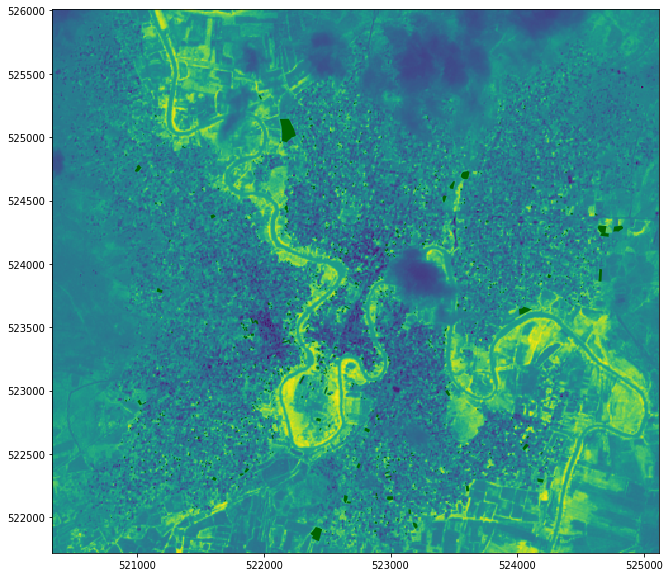

In [45]:
fig, ax = plt.subplots(figsize=(12, 10))
show(ndwi_raster, ax=ax)
buildings[buildings["max_ndwi"].between(0.4, 0.6)].plot(color="darkgreen", ax=ax)
plt.show();

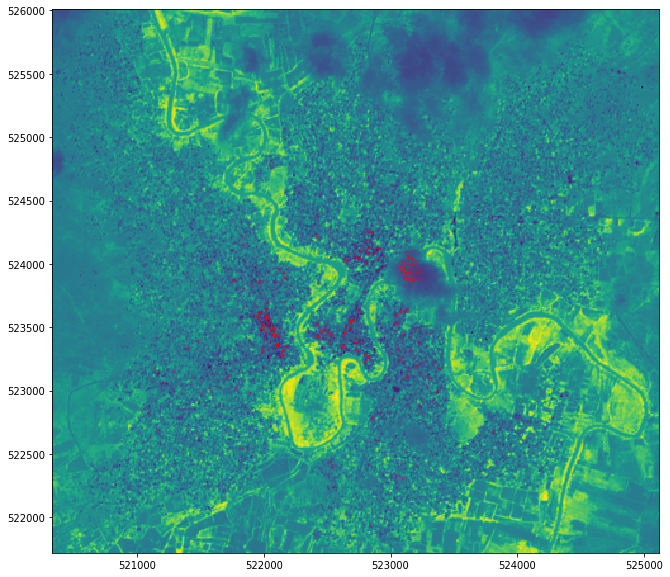

In [46]:
fig, ax = plt.subplots(figsize=(12, 10))
show(ndwi_raster, ax=ax)
buildings[buildings["max_ndwi"].between(0, 0.1)].plot(color="red", ax=ax)
plt.show();